In [19]:
import h5py
import numpy as np
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import matplotlib.pyplot as plt

In [20]:
def inspect_mat_structure(mat_path):
    """데이터 구조를 상세히 출력"""
    with h5py.File(mat_path, 'r') as f:
        print("=== 최상위 그룹 ===")
        print(f.keys())

        print("\n=== Subj_Wins 내부 ===")
        print(f['Subj_Wins'].keys())

        # PPG 참조 배열 확인
        ppg_refs = f['Subj_Wins']['PPG_F'][0]
        print(f"\n=== PPG 참조 개수 ===")
        print(f"총 {len(ppg_refs)}개 샘플")

        # 첫 번째 샘플 상세 정보
        print("\n=== 첫 번째 샘플 정보 ===")
        ppg_0 = f[ppg_refs[0]][()]
        print(f"PPG 원본 shape: {ppg_0.shape}")
        print(f"PPG squeeze 후: {ppg_0.squeeze().shape}")
        print(f"PPG 데이터 타입: {ppg_0.dtype}")

        sbp_0 = f[f['Subj_Wins']['SegSBP'][0][0]][()]
        print(f"\nSBP 원본 shape: {sbp_0.shape}")
        print(f"SBP 값: {sbp_0[0][0]}")

# 실행
inspect_mat_structure("/content/drive/MyDrive/AI_data/p044036.mat")

=== 최상위 그룹 ===
<KeysViewHDF5 ['#refs#', 'Subj_Wins']>

=== Subj_Wins 내부 ===
<KeysViewHDF5 ['ABP_F', 'ABP_Lag', 'ABP_Raw', 'ABP_SPeaks', 'ABP_Turns', 'Age', 'CaseID', 'ECG_F', 'ECG_RPeaks', 'ECG_Raw', 'ECG_Record', 'ECG_Record_F', 'Gender', 'IncludeFlag', 'PPG_ABP_Corr', 'PPG_F', 'PPG_Raw', 'PPG_Record', 'PPG_Record_F', 'PPG_SPeaks', 'PPG_Turns', 'SegDBP', 'SegSBP', 'SegmentID', 'SubjectID', 'T', 'WinID', 'WinSeqID']>

=== PPG 참조 개수 ===
총 1696개 샘플

=== 첫 번째 샘플 정보 ===
PPG 원본 shape: (1, 1250)
PPG squeeze 후: (1250,)
PPG 데이터 타입: float64

SBP 원본 shape: (1, 1)
SBP 값: 125.54237307452473


In [21]:
def load_signals(mat_path, num_samples=1600):
    with h5py.File(mat_path, 'r') as f:
        ppg_refs = f['Subj_Wins']['PPG_F'][0]
        ecg_refs = f['Subj_Wins']['ECG_F'][0]
        sbp_refs = f['Subj_Wins']['SegSBP'][0]
        dbp_refs = f['Subj_Wins']['SegDBP'][0]

        X = []
        y = []
        for i in range(num_samples):
            ppg = f[ppg_refs[i]][()].squeeze().astype(np.float32)
            ecg = f[ecg_refs[i]][()].squeeze().astype(np.float32)
            X.append(np.stack([ppg, ecg], axis=1))

            sbp = f[sbp_refs[i]][()][0][0]
            dbp = f[dbp_refs[i]][()][0][0]
            y.append([sbp, dbp])

    return np.array(X), np.array(y)

X, y = load_signals("/content/drive/MyDrive/AI_data/p044036.mat", 1600)

print(X.shape, y.shape)

(1600, 1250, 2) (1600, 2)


In [22]:
print("X NaN 개수:", np.isnan(X).sum())
print("y NaN 개수:", np.isnan(y).sum())
print("X Inf 개수:", np.isinf(X).sum())
print("y Inf 개수:", np.isinf(y).sum())

X NaN 개수: 0
y NaN 개수: 0
X Inf 개수: 0
y Inf 개수: 0


In [24]:
def plot_regression_history(history):
    """
    회귀 문제 학습 히스토리 플롯 함수
    - loss (train, val)만 출력
    """

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 5))
    plt.plot(train_loss, 'r', label='Training Loss')
    plt.plot(val_loss, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Value')
    plt.legend()
    plt.grid(True)
    plt.show()

In [25]:
def sbp_dbp_mae(y_test, y_pred, fold_idx):
    # SBP와 DBP 분리 (첫 번째 열이 SBP, 두 번째 열이 DBP)
    sbp_true = y_test[:, 0]
    sbp_pred = y_pred[:, 0]
    dbp_true = y_test[:, 1]
    dbp_pred = y_pred[:, 1]

    # 각각의 MAE 계산
    sbp_mae = np.mean(np.abs(sbp_true - sbp_pred))
    dbp_mae = np.mean(np.abs(dbp_true - dbp_pred))

    print(f"Fold {fold_idx} SBP MAE: {sbp_mae:.4f}")
    print(f"Fold {fold_idx} DBP MAE: {dbp_mae:.4f}")

    return sbp_mae, dbp_mae


===== Fold 1 =====
Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 272ms/step - loss: 89.6696 - mae: 89.6696 - val_loss: 87.4725 - val_mae: 87.4725
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 83.4631 - mae: 83.4631 - val_loss: 68.8037 - val_mae: 68.8037
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 56.1959 - mae: 56.1959 - val_loss: 28.7775 - val_mae: 28.7775
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 27.4728 - mae: 27.4728 - val_loss: 17.9399 - val_mae: 17.9399
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 14.5568 - mae: 14.5568 - val_loss: 7.0247 - val_mae: 7.0247
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.3992 - mae: 5.3992 - val_loss: 5.9712 - val_mae: 5.9712
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.4791 - mae: 5.4791 - val_loss: 3.1603 - val_mae: 3.1603
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4.2445 - mae: 4.2445 - val_loss: 2.7836 - val_mae: 2.7836
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22

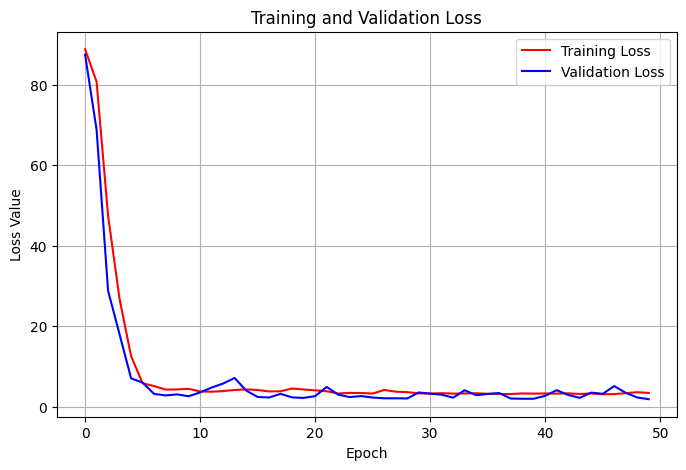

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step
Fold 1 SBP MAE: 5.0906
Fold 1 DBP MAE: 1.4304

===== Fold 2 =====
Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 270ms/step - loss: 89.6365 - mae: 89.6365 - val_loss: 88.4830 - val_mae: 88.4830
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 86.9255 - mae: 86.9255 - val_loss: 81.6380 - val_mae: 81.6380
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 76.6538 - mae: 76.6538 - val_loss: 51.2998 - val_mae: 51.2998
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 38.8874 - mae: 38.8874 - val_loss: 21.2870 - val_mae: 21.2870
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 17.4640 - mae: 17.4640 - val_loss: 15.2196 - val_mae: 15.2196
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 14.1118 - mae: 14.1118 - val_loss: 6.5526 - val_mae: 6.5526
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 8.4025 - mae: 8.4025 - val_loss: 6.7881 - val_mae: 6.7881
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 7.4457 - ma

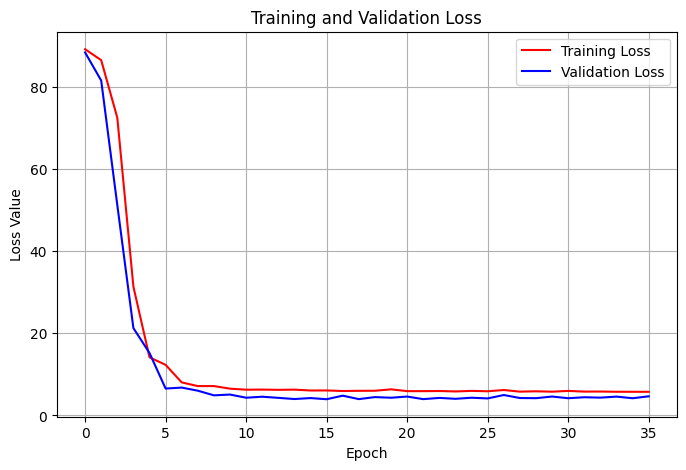

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step
Fold 2 SBP MAE: 9.8329
Fold 2 DBP MAE: 7.1444

===== Fold 3 =====
Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 273ms/step - loss: 86.6544 - mae: 86.6544 - val_loss: 88.6114 - val_mae: 88.6114
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 80.7638 - mae: 80.7638 - val_loss: 69.4310 - val_mae: 69.4310
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 52.0203 - mae: 52.0203 - val_loss: 4.8894 - val_mae: 4.8894
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 15.0712 - mae: 15.0712 - val_loss: 14.1217 - val_mae: 14.1217
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 8.7983 - mae: 8.7983 - val_loss: 2.3739 - val_mae: 2.3739
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.5033 - mae: 5.5033 - val_loss: 8.3147 - val_mae: 8.3147
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.5652 - mae: 3.5652 - val_loss: 8.0760 - val_mae: 8.0760
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.6693 - mae: 3.669

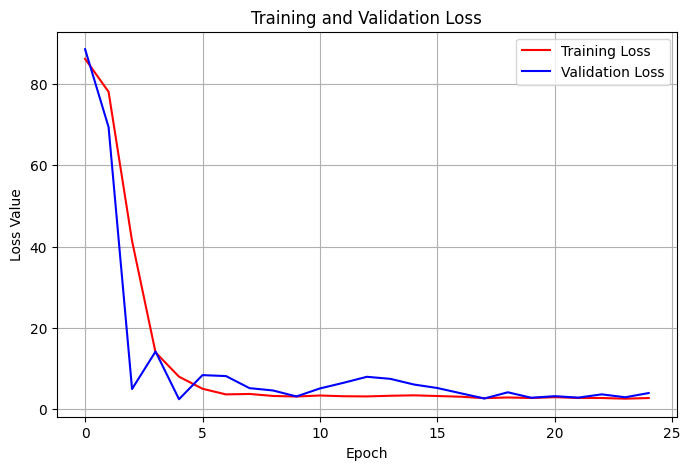

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step
Fold 3 SBP MAE: 3.2167
Fold 3 DBP MAE: 2.6206

===== Fold 4 =====
Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 270ms/step - loss: 89.0837 - mae: 89.0837 - val_loss: 87.3492 - val_mae: 87.3492
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 85.9782 - mae: 85.9782 - val_loss: 77.2818 - val_mae: 77.2818
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 71.0098 - mae: 71.0098 - val_loss: 36.2715 - val_mae: 36.2715
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 30.8052 - mae: 30.8052 - val_loss: 23.4238 - val_mae: 23.4238
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 17.3848 - mae: 17.3848 - val_loss: 10.9303 - val_mae: 10.9303
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.2269 - mae: 9.2269 - val_loss: 7.0089 - val_mae: 7.0089
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.9982 - mae: 5.9982 - val_loss: 3.8503 - val_mae: 3.8503
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.0918 - mae:

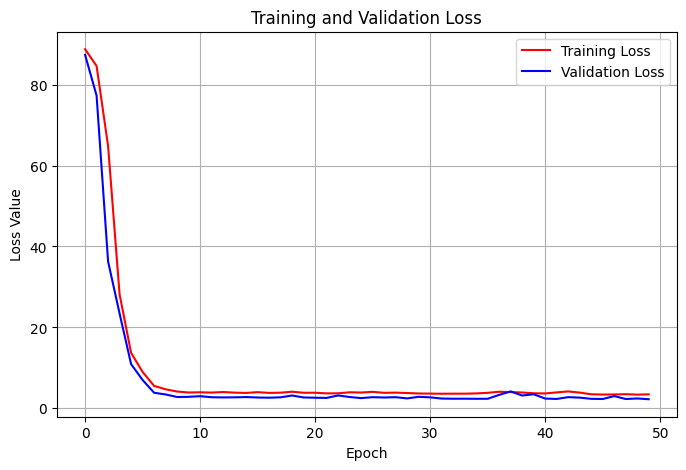

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step
Fold 4 SBP MAE: 5.8575
Fold 4 DBP MAE: 2.6244


In [26]:
# Fold 정의
folds = [
    (0, 300, 300, 400),
    (400, 700, 700, 800),
    (800, 1100, 1100, 1200),
    (1200, 1500, 1500, 1600)
]

input_shape = X.shape[1:] # (1250, 2)
sbp_mae_scores = []
dbp_mae_scores = []

for fold_idx, (train_start, train_end, test_start, test_end) in enumerate(folds, 1):
    print(f"\n===== Fold {fold_idx} =====")

    # Train/Val/Test 분리
    X_train_full, y_train_full = X[train_start:train_end], y[train_start:train_end]
    X_val, y_val = X_train_full[-60:], y_train_full[-60:]     # 마지막 60개 → Validation
    X_train, y_train = X_train_full[:-60], y_train_full[:-60] # 나머지 → Train
    X_test, y_test = X[test_start:test_end], y[test_start:test_end]

    # StandardScaler 적용 (채널별로)
    scalers = []
    for ch in range(X.shape[2]):
        scaler = StandardScaler()
        # 2D로 reshape → (samples * timesteps, 1)
        X_train_ch = X_train[:, :, ch].reshape(-1, 1)
        scaler.fit(X_train_ch)
        scalers.append(scaler)

        # transform
        X_train[:, :, ch] = scaler.transform(X_train[:, :, ch].reshape(-1, 1)).reshape(X_train[:, :, ch].shape)
        X_val[:, :, ch]   = scaler.transform(X_val[:, :, ch].reshape(-1, 1)).reshape(X_val[:, :, ch].shape)
        X_test[:, :, ch]  = scaler.transform(X_test[:, :, ch].reshape(-1, 1)).reshape(X_test[:, :, ch].shape)

    # 모델 정의
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(64, kernel_size=5, padding='same', activation='relu'),
        Conv1D(128, kernel_size=3, padding='same', activation='relu'),
        MaxPooling1D(pool_size=2),
        Conv1D(256, kernel_size=3, padding='same', activation='relu'),
        GlobalAveragePooling1D(),
        Dense(64, activation='relu'),
        # linear는 출력값 그대로 반환, 범위 제한 없음 → 혈압처럼 60~200까지 자유롭게 예측 가능
        Dense(2, activation='linear')
    ])

    model.compile(optimizer='adam', loss='mae', metrics=['mae'])

    # EarlyStopping (val_loss 기준)
    es = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True, verbose=1)

    history = model.fit(
        X_train, y_train,
        epochs=50,
        validation_data=(X_val, y_val),
        callbacks=[es],
        verbose=1
    )

    plot_regression_history(history)

    y_pred = model.predict(X_test)
    sbp_mae, dbp_mae = sbp_dbp_mae(y_test, y_pred, fold_idx)
    sbp_mae_scores.append(sbp_mae)
    dbp_mae_scores.append(dbp_mae)

In [28]:
# 최종 평균/표준편차
print("\n===== Cross-Validation Result =====")
print("SBP MAE per fold:", [f"{v:.4f}" for v in sbp_mae_scores])
print("DBP MAE per fold:", [f"{v:.4f}" for v in dbp_mae_scores])

print(f"\nAverage SBP MAE: {np.mean(sbp_mae_scores):.4f}")
print(f"Std SBP MAE: {np.std(sbp_mae_scores):.4f}")

print(f"\nAverage DBP MAE: {np.mean(dbp_mae_scores):.4f}")
print(f"Std DBP MAE: {np.std(dbp_mae_scores):.4f}")


===== Cross-Validation Result =====
SBP MAE per fold: ['5.0906', '9.8329', '3.2167', '5.8575']
DBP MAE per fold: ['1.4304', '7.1444', '2.6206', '2.6244']

Average SBP MAE: 5.9994
Std SBP MAE: 2.4127

Average DBP MAE: 3.4550
Std DBP MAE: 2.1850
